**Rocks Classifictions**

**Import important library and Function**

In [1]:

import numpy as np
import pandas as pd  
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import cv2

import seaborn as sns
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense,Flatten , Conv2D , MaxPooling2D , Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
path='/kaggle/input/algerian-used-cars/dataset/DATA'
filepaths=[]
labels=[]

for label in os.listdir(path):
        for i in os.listdir(path+"/"+label):
            filepaths.append(path+"/"+label+'/'+i)
            labels.append(label)
      

In [3]:
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))
pd.Series(labels).value_counts()

filepaths:  3235    labels:  3235


clio                 344
megane               280
duster               280
sandero              260
volkswagen tiguan    184
picanto              178
Golf                 160
symbol               158
octavia              156
toyota corolla       150
polo                 132
hyundai i10          130
chevroulet aveo      129
hyundai tucson       128
logan                112
chevrolet spark      108
seat ibiza           100
mercedes class a      84
bmw serie 1           82
nemo citroen          80
dtype: int64

**Save the paths of images in data frame**

In [4]:
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)

balance=df['labels'].value_counts()
print (balance) 

clio                 344
megane               280
duster               280
sandero              260
volkswagen tiguan    184
picanto              178
Golf                 160
symbol               158
octavia              156
toyota corolla       150
polo                 132
hyundai i10          130
chevroulet aveo      129
hyundai tucson       128
logan                112
chevrolet spark      108
seat ibiza           100
mercedes class a      84
bmw serie 1           82
nemo citroen          80
Name: labels, dtype: int64


In [5]:
## Split dataset into train, valid and test sets
#shape transfer to 4 dimensions (total, height,width,channel)

height=224
width=224
channels=3
batch_size=60
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.8
test_split=.1

dummy_split=test_split/(1-train_split)

train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)


print (len(train_df), len(test_df), len(valid_df))
vcounts=train_df['labels'].value_counts()
print (vcounts)
#vmin=np.min(list(vcounts))
#print(vmin)

2588 323 324
clio                 263
megane               233
duster               225
sandero              208
picanto              143
symbol               137
volkswagen tiguan    134
octavia              134
Golf                 129
toyota corolla       126
hyundai i10          106
polo                 105
chevroulet aveo      105
hyundai tucson        96
logan                 86
chevrolet spark       83
seat ibiza            77
bmw serie 1           67
nemo citroen          66
mercedes class a      65
Name: labels, dtype: int64


**Create file to save augement Image** 

**Load training and validation sets and make augmentation**

In [6]:
FILEPATH = '/kaggle/working/Dataset/' # filepath for data
BATCH_SIZE = 64# keras training batch size
IMAGE_SIZE = (224, 224) # size of images in dataset (keras will resize)


ROUND_1_TRAINABLE_LAYERS = 0 # layers at end of the mobile_net base model to have trainable parameters
ROUND_1_EPOCHS = 10

ROUND_2_TRAINABLE_LAYERS = 38
ROUND_2_LEARNING_SCALER = 0.2
ROUND_2_EPOCHS = 10

ROUND_3_TRAINABLE_LAYERS = 74
ROUND_3_LEARNING_SCALER = 0.2
ROUND_3_EPOCHS = 10

LEARNING_RATE = 0.0001

MODEL_CHECKPOINT_FILEPATH = './Bird-Classifier-Model-Checkpoint.ckpt'

SEED = 6278 # random seed for repeatability of notebook

In [7]:
## Generate train, test, valid
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True, rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      
      validation_split=0.2,
      
      fill_mode='nearest')
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 2588 validated image filenames belonging to 20 classes.
Found 323 validated image filenames belonging to 20 classes.
Found 324 validated image filenames belonging to 20 classes.


**Bulid the model**

In [8]:
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint


In [9]:
# # i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer

mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(20, activation="softmax" , name="classification"))

17235968/17225924 [==============================] - 0s 0us/step


In [10]:
optimizer_1 = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

callbacks = [model_checkpoint]

model.compile(optimizer = optimizer_1,
              loss = loss,
              metrics=['accuracy'])

In [11]:
hist = model.fit(train_gen,validation_data=valid_gen, epochs=100, callbacks=callbacks )

Epoch 1/100
44/44 [==============================] - 65s 1s/step - loss: 2.5795 - accuracy: 0.2608 - val_loss: 2.3587 - val_accuracy: 0.2994

Epoch 00001: val_accuracy improved from -inf to 0.29938, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 2/100
44/44 [==============================] - 39s 880ms/step - loss: 1.5199 - accuracy: 0.5951 - val_loss: 1.7232 - val_accuracy: 0.4846

Epoch 00002: val_accuracy improved from 0.29938 to 0.48457, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 3/100
44/44 [==============================] - 39s 871ms/step - loss: 0.8054 - accuracy: 0.7825 - val_loss: 1.0766 - val_accuracy: 0.7099

Epoch 00003: val_accuracy improved from 0.48457 to 0.70988, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
Epoch 4/100
44/44 [==============================] - 39s 888ms/step - loss: 0.4659 - accuracy: 0.8779 - val_loss: 0.7542 - val_accuracy: 0.7778

Epoch 00004: val_accuracy improved from 0.70988 to 0.77778, saving model to ./

**Evaluate the model**

In [12]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH)

test_loss, test_accuracy = model.evaluate(test_gen)

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

6/6 [==============================] - 3s 437ms/step - loss: 0.0177 - accuracy: 0.9938

The model had an accuracy score of 99.4%!!


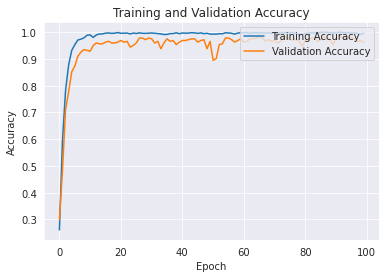

In [13]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()
